### POS tagging using Conditional Random Fields(CRFs)

In [1]:
# Imports

import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

from itertools import chain
import nltk
import sklearn

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [3]:
from io import open
from conllu import parse, parse_tree, parse_incr

# Data files
train_df = 'hi-ud-train.conllu'
test_df = 'hi-ud-test .conllu'

# Extract Data function
def extract_data(data_file, delimiter = ','):
    corpus = open(data_file, "r", encoding="utf-8").readlines()
    sents = []
    sample = []
    for sent in corpus[1:]:
        processed_sent = sent.strip('\n').split(delimiter)
        if processed_sent == ['', '', '']:
            sents.append(sample)
            sample = []
        else:
            sample.append(processed_sent)
    return sents

# Train
train_sents = extract_data(train_df, ',')

# Test
test_sents = extract_data(test_df, '\t')

### Feature Description
<ol>
<li>Index</li>
<li>Word</li>
<li>Suffices</li>
<li>Prefices</li>
<li>Is Uppercase?</li>
<li>Is Title?</li>
<li>Is Digit?</li>
<li>Preceding Word</li>
<li>Succeeding Word</li>
</ol>

##### where,  
**Index:** Position of the word in the sentence  
**Word:** Lowercase version of the current word  
**Suffix:** 1, 2, 3-length suffices of the word  
**Prefix:** 1, 2, 3-length prefices of the word  
**Preceding and Succeeding Words** Features 2, 5, 6, 7 for the previous and next words in the sentence

#### Justification:
Index was included to encode the position of the word in the sentence. Suffices and Prefices were added to give a sense of the tense and word-form. Other small features(case, digit) were also included. Previous and Next words were included to give a sense of the context.  
Stemmed version of word was tried as well. But it gave negligible improvements in performance due to redundancy with word suffix, prefix-features.

In [4]:
# Word Feature Extraction for CRF
def word2features(sent, i):
    index = sent[i][0]
    word = sent[i][1]
    postag = sent[i][2]

    features = {
        'bias': 1.0,
        'index': index,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word[-1:]': word[-1:],
        'word[:3]': word[:3],
        'word[:2]': word[:2],
        'word[:1]': word[:1],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:word.isdigit()': word1.isdigit(),
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:word.isdigit()': word1.isdigit(),
        })
    else:
        features['EOS'] = True

    return features

# Sentence Feature Extraction
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [postag for index, token, postag in sent]

def sent2tokens(sent):
    return [token for index, token, postag in sent]

In [5]:
# Collecting data
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

In [6]:
# Initialise CRF model by defining hyper-parameters
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

# Train the model
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [7]:
labels = list(crf.classes_)
print("All POS-labels in training data: ")
print(labels)

All POS-labels in training data: 
['DET', 'PROPN', 'ADP', 'ADV', 'ADJ', 'NOUN', 'NUM', 'AUX', 'PUNCT', 'PRON', 'VERB', 'CCONJ', 'PART', 'COMMA', 'SCONJ', 'X']


In [8]:
# Make predictions and generate metrics
y_train_pred = crf.predict(X_train)
f1 = metrics.flat_f1_score(y_train, y_train_pred, average='weighted', labels=labels)
acc = metrics.flat_accuracy_score(y_train, y_train_pred)

print("Results on Train set: ")
print("Accuracy = {}, F1 score = {}".format(acc, f1))
print("-"*70)

y_pred = crf.predict(X_test)
f1 = metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels)
acc = metrics.flat_accuracy_score(y_test, y_pred)

print("Results on Test set: ")
print("Accuracy = {}, F1 score = {}".format(acc, f1))

Results on Train set: 
Accuracy = 0.9817057120294814, F1 score = 0.9816811705060093
----------------------------------------------------------------------
Results on Test set: 
Accuracy = 0.8511080332409973, F1 score = 0.8490774222129278


In [9]:
# Print Classification report
# Sort Labels
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)

print("Results on Train Set: ")
print(metrics.flat_classification_report(
    y_train, y_train_pred, labels=sorted_labels, digits=3
))

print("-"*70)

print("Results on Test Set: ")
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

Results on Train Set: 
              precision    recall  f1-score   support

           X      1.000     1.000     1.000         2
        PART      0.994     1.000     0.997       163
       CCONJ      0.987     1.000     0.993       150
       SCONJ      0.984     1.000     0.992        61
         ADJ      0.982     0.981     0.982       569
         ADP      0.984     0.993     0.988      1384
         ADV      0.890     0.882     0.886       110
        VERB      0.992     0.956     0.974       639
         DET      0.937     0.970     0.953       230
       COMMA      1.000     1.000     1.000       114
        NOUN      0.981     0.984     0.982      1596
        PRON      0.986     0.958     0.972       430
       PROPN      0.986     0.970     0.978       707
         NUM      0.980     0.987     0.984       152
       PUNCT      1.000     1.000     1.000       563
         AUX      0.971     0.996     0.983       728

    accuracy                          0.982      7598
   

### Hyperparameter Search using RandomizedSearchCV

In [10]:
# Hyperparameter Search

import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

# Define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.1),
    'c2': scipy.stats.expon(scale=0.1),
}

# Use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# Search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer);
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=True, averaging=None,
                                 c=None, c1=None, c2=None,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None, gamma=None,
                                 keep_...
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f73110f6490>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f73110284d0>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,


In [11]:
# Extract model with the best Cross-Validation Score in the train-set
crf = rs.best_estimator_
print('Best params:', rs.best_params_)
print('Best CV score:', rs.best_score_)
print('Model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

Best params: {'c1': 0.008851051652355212, 'c2': 0.05179922878053938}
Best CV score: 0.8383990355496969
Model size: 0.41M


White => 0.8282, Black => 0.8384


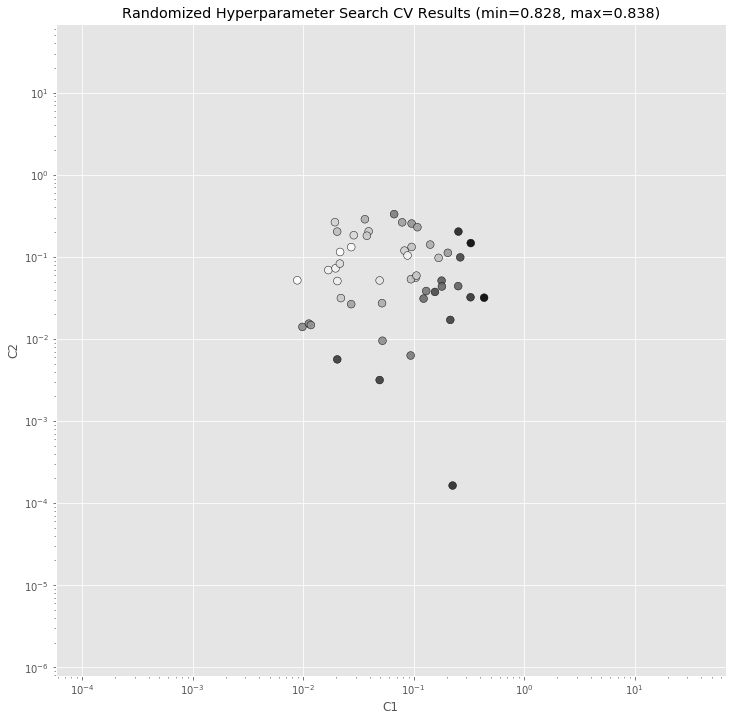

In [12]:
# Plotting parameter values and variation with score
_x = rs.cv_results_["param_c1"]
_y = rs.cv_results_["param_c2"]
_c = rs.cv_results_["mean_test_score"]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0], cmap='gray')

print("White => {:0.4}, Black => {:0.4}".format(min(_c), max(_c)))

In [17]:
# Print Classification report for the model after hyperparameter tuning
# Best Model
crf = rs.best_estimator_

y_train_pred = crf.predict(X_train)
print("Results on Train Set: ")
acc = metrics.flat_accuracy_score(y_train, y_train_pred)
print("Accuracy: {}".format(acc))
print(metrics.flat_classification_report(
    y_train, y_train_pred, labels=sorted_labels, digits=3
))

print("-"*70)

y_pred = crf.predict(X_test)
print("Results on Test Set: ")
acc = metrics.flat_accuracy_score(y_test, y_pred)
print("Accuracy: {}".format(acc))
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))
acc = metrics.flat_accuracy_score(y_test, y_pred)

Results on Train Set: 
Accuracy: 0.9880231639905238
              precision    recall  f1-score   support

           X      1.000     1.000     1.000         2
        PART      1.000     1.000     1.000       163
       CCONJ      0.993     1.000     0.997       150
       SCONJ      1.000     1.000     1.000        61
         ADJ      0.991     0.991     0.991       569
         ADP      0.989     0.993     0.991      1384
         ADV      0.910     0.918     0.914       110
        VERB      0.995     0.959     0.977       639
         DET      0.950     0.983     0.966       230
       COMMA      1.000     1.000     1.000       114
        NOUN      0.992     0.992     0.992      1596
        PRON      0.988     0.967     0.978       430
       PROPN      0.991     0.987     0.989       707
         NUM      1.000     1.000     1.000       152
       PUNCT      1.000     1.000     1.000       563
         AUX      0.971     0.999     0.984       728

    accuracy                

**We observe slightly worse performance after hyper-parameter tuning using RandomizedSearchCV as compared to default setting. But we can expect better performance in any other held-out test-set, as compared to the untuned setting.**

In [14]:
# Generating Transition Features
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Transition Features in Train-Set")
print("-"*40)
print("Top 10 likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(10))

print("\nTop 10 unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-10:])

Transition Features in Train-Set
----------------------------------------
Top 10 likely transitions:
VERB   -> AUX     4.030280
PROPN  -> PROPN   3.106717
AUX    -> AUX     2.597757
PART   -> NUM     2.231922
DET    -> NOUN    2.069556
ADJ    -> NOUN    2.011666
VERB   -> SCONJ   1.994042
PROPN  -> ADP     1.883917
ADP    -> ADP     1.802217
PRON   -> ADP     1.783447

Top 10 unlikely transitions:
NUM    -> PRON    -1.907306
DET    -> CCONJ   -2.012440
ADV    -> ADV     -2.277243
CCONJ  -> PART    -2.581278
CCONJ  -> AUX     -2.741781
DET    -> ADP     -2.886974
ADJ    -> PRON    -2.960006
ADV    -> AUX     -3.013792
ADJ    -> ADP     -3.023667
ADP    -> COMMA   -3.556746


***Since the CRF model is trained on the train-dataset only, it is unable to extract transition features for the test dataset. For that, we train a dummy CRF model on the test dataset to get an idea of the test Transition features and their likelihood of occuring.***

In [15]:
# Generating Transition Features for Test set
crf_dummy = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf_dummy.fit(X_test, y_test)

print("Transition Features in Test-Set")
print("-"*40)
print("Top 10 likely transitions:")
print_transitions(Counter(crf_dummy.transition_features_).most_common(10))

print("\nTop 10 unlikely transitions:")
print_transitions(Counter(crf_dummy.transition_features_).most_common()[-10:])

Transition Features in Test-Set
----------------------------------------
Top 10 likely transitions:
VERB   -> AUX     3.046096
AUX    -> AUX     2.688487
PROPN  -> PROPN   2.341409
PROPN  -> ADP     2.054003
NUM    -> NUM     1.856905
AUX    -> PUNCT   1.824838
VERB   -> PUNCT   1.745669
PART   -> NUM     1.579147
ADV    -> DET     1.575871
PROPN  -> CCONJ   1.485642

Top 10 unlikely transitions:
AUX    -> VERB    -0.883839
DET    -> ADP     -1.013453
NOUN   -> DET     -1.224370
VERB   -> PROPN   -1.233202
DET    -> PROPN   -1.355719
ADP    -> PUNCT   -1.360454
PROPN  -> AUX     -1.399564
NOUN   -> NOUN    -1.425669
PROPN  -> ADJ     -1.676554
ADJ    -> ADP     -1.821706
